# ABC Music Consultants: Report on Chinook Music

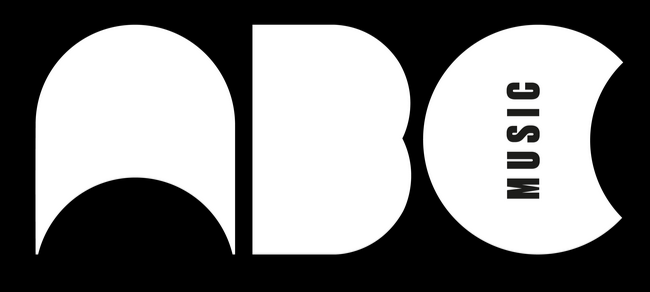

# Index

- [1 Introduction](#1)
- [2 Chinook...who? or is it what?](#2)
- [3 What do you seek?](#3)
- [4 Music in us? No...The US!](#4)
- [5 Sell me this pen.....](#5)
- [6 International Love](#6)
- [7 Loyalty](#7)
- [8 Singles or Albums](#8)
- [9 And the award for the most popular artist....](#9)
- [10 Purchased vs. Unpurchased tracks](#10)
- [11 Have you got what they love?](#11)
- [12 Protected vs. UnProtected....media!](#12)
- [13 Conclusion](#13)
- [14 Acknowledgement](#14)

# 1

## Introduction

Chinook Music is a fictional online music store based out of Canada. The online store has been up and running for a while and is being managed by a team of 8. 

A reputed record label (who shall remain nameless because of NDA (Non-Disclosure Agreement) clauses in the signed contract) is keen on signing up with Chinook Music to promote their artists and labels.

Since this is a huge deal with a contract worth millions, ABC(Always Been Cheeky) Music Consultants were approached to go over the records at Chinook Music and provide a report on certain questions that the board had. In addition to answering some specific questions from C-suite executives, ABC has been tasked with providing suggestions based on their extensive experience in the industry.

[Index](#Index)

# 2

## Chinook...who? or is it what?

**A more detailed look in to Chinook Music's operations and an overview on their DB**

As was seen earlier Chinook Music is an online music store. Chinook Music has a wide range of tracks of different genres from various record labels. Chinook's inventory consists of audio and video tracks. Customers may buy a whole album by selecting individual tracks or buy individual tracks from different albums.

Their close customer interaction sets them apart from other their competitors. Every customer in Chinook Music is assigned a Sales Support Agent after their first sale. The support agent is a key driver of sales at Chinook.

Chinook Music has a wide reach in terms of customers. Their customers span across 24 countries in 6 continents.

The schema for chinook.db has been provided below. 

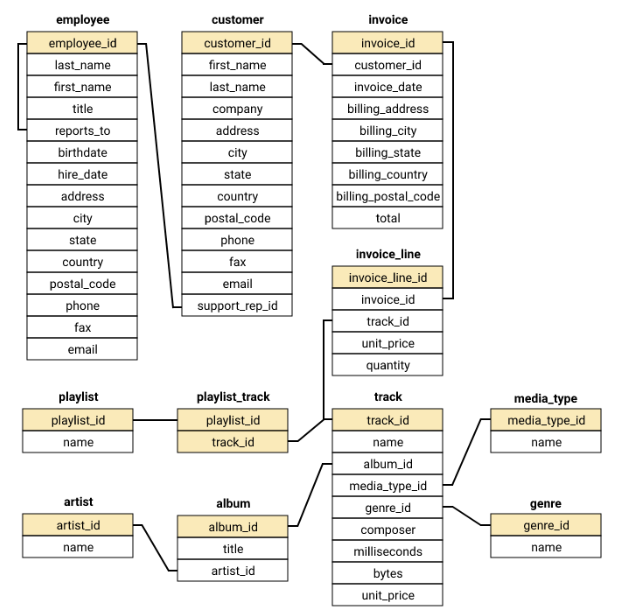

- Every sales employee in Chinook is as assinged to a customer. The sales support staff employee id is stored as support_rep_id in the customer table.
- Every customer will get a purchase invoice.
- A single invoice consists of multiple invoice lines containing details of every track bought in the invoice
- Every track has details that include its genre, the album it belongs to and its media type.
- Playlists uploaded by the user are maintained in a separate table with no reference to the customer that created the playlist. A single playlist can contain multiple tracks from multiple artists or the same artist.

In order to begin analysis, the DB must be loaded in to jupyter.

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

Once loaded we can verify its existence

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


Because of the volume of data there is potential to plot the data on different plots. Taking this in to consideration, we are considering loading outputs of SQL queries and loading the same in to dataframes, which would allow the creation of plots.

The chinook DB will be loaded and we can verify that the db has been loaded by viewing the data in one of the tables in a dataframe.

In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
conn = sqlite3.connect('chinook.db')
df = pd.read_sql_query("""SELECT * 
                          FROM media_type;""", conn)
df

,media_type_id,name
0,1,MPEG audio file
1,2,Protected AAC audio file
2,3,Protected MPEG-4 video file
3,4,Purchased AAC audio file
4,5,AAC audio file


Since data has been successfully loaded, the DB can now be assessed.

[Index](#Index)

# 3

## What do you seek?

**A look in to the queries or assessments required by the record label board**

After several discussions with multiple high level stakeholders. The following questions and assessments need to be answered and made respectively by ABC consultants.

1. The record label has four upcoming albums by four different artists from four different genres namely Hip-Hop, Punk, Pop and Blues. The artists are all from the USA. The record label is keen on knowing which genres have good traction in US markets?

2. Given the close interaction between sales staff and customers, the record label company is keen on assessing the performance of sales staff and whether they are capable enough to drive sales in the future.

3. Considering the variety of customer markets held by Chinook. The record label is interested in an assessment of sales across these markets.

4. Since the customers of Chinook Music can buy tracks or full albums, the record label needs to decide which one to stock Chinook Music with so as to drive sales.

5. Customers can create their own playlists and host them in Chinook. This opens a whole new window in to customer preference. The record label is inquisitive about the artists featured in most playlists.

6. What is inventory turn-over at Chinook look like?

7. Is the track inventory in Chinook based on popular demand?

8. How well does protected media fair versus unprotected media?

[Index](#Index)

# 4

## Music in us? No...The US!

**Popular genres among US customers**

The first question requires us to find out which, among the four provided genres, namely Hip-Hop, Punk, Pop and Blues are popular among US customers. The record label has provided us with details of the artists and their respective genres of music.

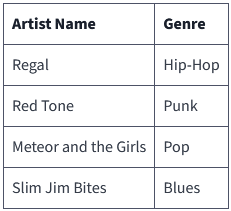

In [5]:
%%sql
CREATE VIEW vw_us_genres AS
WITH
--#Filter customers from USA
usa_customers AS (
                  SELECT customer_id, country
                  FROM customer
                  WHERE country = 'USA'
                 ),
--#Filter invoices of US customers
usa_invoices AS (
                 SELECT inv.invoice_id AS invoice_ids
                 FROM invoice inv
                 INNER JOIN usa_customers usa_cus ON usa_cus.customer_id=inv.customer_id 
                ),
--#Filter invoice lines of invoices of US customers
usa_tracks AS (
               SELECT inv_lin.track_id AS us_track_ids
               FROM invoice_line inv_lin
               INNER JOIN usa_invoices usa_inv ON usa_inv.invoice_ids = inv_lin.invoice_id
              ),
--#Identify the Genre by name for all tracks
track_genres AS (
                 SELECT tra.track_id AS ids, gen.name AS Genres
                 FROM track tra
                 INNER JOIN genre gen ON gen.genre_id = tra.genre_id
                ),
--#Count the number of tracks for each Genre 
--#and calculates the relative percentage among all tracks purchased by US customers
us_track_genres AS (
                    SELECT COUNT(tra_gen.ids) AS track_count, tra_gen.genres, 
                    CAST(COUNT(tra_gen.ids) AS FLOAT) * 100/(
                                                             SELECT COUNT(tra_gen.ids)
                                                             FROM track_genres tra_gen
                                                             INNER JOIN usa_tracks usa_tra ON 
                                                             usa_tra.us_track_ids = tra_gen.ids
                                                             ) AS percentage
                    FROM track_genres tra_gen
                    INNER JOIN usa_tracks usa_tra ON usa_tra.us_track_ids = tra_gen.ids
                    GROUP BY tra_gen.Genres
                    ORDER BY Percentage DESC
                    )
--#Displays the percentage of tracks for the required Genres
SELECT track_count, genres, ROUND(percentage,2) AS 'percentage_of_tracks_sold'
FROM us_track_genres;

 * sqlite:///chinook.db
(sqlite3.OperationalError) table vw_us_genres already exists
[SQL: CREATE VIEW vw_us_genres AS
WITH
--#Filter customers from USA
usa_customers AS (
                  SELECT customer_id, country
                  FROM customer
                  WHERE country = 'USA'
                 ),
--#Filter invoices of US customers
usa_invoices AS (
                 SELECT inv.invoice_id AS invoice_ids
                 FROM invoice inv
                 INNER JOIN usa_customers usa_cus ON usa_cus.customer_id=inv.customer_id 
                ),
--#Filter invoice lines of invoices of US customers
usa_tracks AS (
               SELECT inv_lin.track_id AS us_track_ids
               FROM invoice_line inv_lin
               INNER JOIN usa_invoices usa_inv ON usa_inv.invoice_ids = inv_lin.invoice_id
              ),
--#Identify the Genre by name for all tracks
track_genres AS (
                 SELECT tra.track_id AS ids, gen.name AS Genres
                 FROM track tra
         

In [6]:
%%sql
SELECT *
FROM vw_us_genres
WHERE genres IN ('Hip Hop/Rap', 'Alternative & Punk', 'Pop', 'Blues')

 * sqlite:///chinook.db
Done.


track_count,genres,percentage_of_tracks_sold
130,Alternative & Punk,12.37
36,Blues,3.43
22,Pop,2.09
20,Hip Hop/Rap,1.9


Clearly, **US customers prefer the Alternative & Punk genre** of music over the other provided genres.  Music by the **artist Red Tone makes the cut** and since his/her/their genre makes slightly more than 10% of the share of tracks sold, it makes sense to advertise and sale his/her/their album or tracks more.

For the purpose of making these kind of decisions in the future, it would be interesting to know what shares different genres have in the US market. This is detailed below.

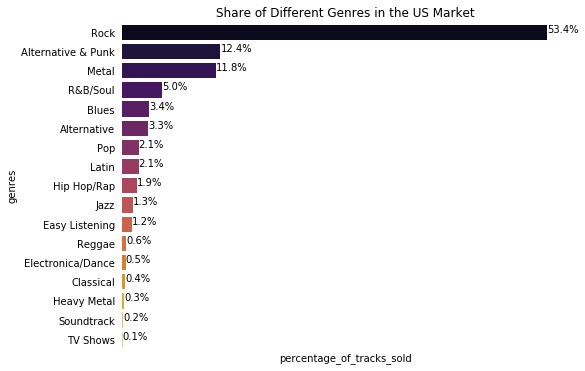

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_sql_query("""SELECT  *
                          FROM vw_us_genres""", conn)

# Setting figure size
plt.figure(figsize=(8,6))

# Highlights survey_fields that have a correlation above 0.2
ax = sns.barplot(x = df['percentage_of_tracks_sold'], 
                 y = df['genres'],
                 data = df,
                 palette = 'inferno', 
                 orient = 'h')

ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(left = False, bottom = False)
ax.set_xticks([])

#Annotating the bargraph
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,
             "%.1f%%"% rect.get_width())
ax.set_title("Share of Different Genres in the US Market")
plt.show()

**American customers prefer Rock music** most over any other genres. Therefore rock albums and tracks must be easier to sell to American audiences.

[Index](#Index)

# 5

## Sell me this pen.....

**Analyzing the performance of the sales support staff**

As seen earlier, the sales team drives the sales at Chinook Music. We can analyze the total sales they've made since they were hired. This should be a good indicator of their performance.

In [8]:
%%sql
WITH
--# Summarize the invoice totals for each customer in the customer table
customer_sales AS (
                    SELECT cus.customer_id, SUM(inv.total) AS sum_of_purchases_of_customer
                    FROM customer cus
                    INNER JOIN invoice inv ON cus.customer_id = inv.customer_id
                    GROUP BY cus.customer_id
                   ),
--# Associate the Sales rep to the total of their customer's purchase
cust_sale_total AS(
                    SELECT cus_sal.customer_id, cus_sal.sum_of_purchases_of_customer, cus.support_rep_id AS sales_rep
                    FROM customer_sales cus_sal
                    INNER JOIN customer cus ON cus_sal.customer_id = cus.customer_id)

--# Summarize the purchases of all customers associated to the Sales rep and display the same with date of hire
SELECT emp.first_name ||' '||emp.last_name AS sales_rep_name, 
       emp.hire_date AS date_of_hire, 
       ROUND(SUM(cus_sal_tot.sum_of_purchases_of_customer),2) AS total_sales_made_in_$
FROM employee emp
LEFT JOIN cust_sale_total cus_sal_tot ON emp.employee_id = cus_sal_tot.Sales_rep
GROUP BY emp.employee_id
HAVING title = 'Sales Support Agent'

 * sqlite:///chinook.db
Done.


sales_rep_name,date_of_hire,total_sales_made_in_$
Jane Peacock,2017-04-01 00:00:00,1731.51
Margaret Park,2017-05-03 00:00:00,1584.0
Steve Johnson,2017-10-17 00:00:00,1393.92


Based on the data, there is no significant difference in the sales generated by the individual sales staff considering that they have joined at three different times during the same year.

It must be noted, that the first sale for the year 2017, the year the three individuals joined, was on Jan 3rd. This is an anomaly considering that Jane Peacock, the first hire to the team only joined on April 1st of the same year.

In [9]:
%%sql
SELECT inv.customer_id, inv.invoice_date, inv.total, emp.first_name AS sales_rep_first_name 
FROM invoice inv
INNER JOIN customer cus ON cus.customer_id = inv.customer_id
INNER JOIN employee emp ON cus.support_rep_id = emp.employee_id
WHERE invoice_date < '2017-04-01 00:00:00'
LIMIT 10

 * sqlite:///chinook.db
Done.


customer_id,invoice_date,total,sales_rep_first_name
18,2017-01-03 00:00:00,15.84,Jane
30,2017-01-03 00:00:00,9.9,Jane
40,2017-01-05 00:00:00,1.98,Margaret
18,2017-01-06 00:00:00,7.92,Jane
27,2017-01-07 00:00:00,16.83,Margaret
31,2017-01-10 00:00:00,1.98,Steve
49,2017-01-12 00:00:00,10.89,Margaret
59,2017-01-13 00:00:00,9.9,Jane
18,2017-01-18 00:00:00,8.91,Jane
31,2017-01-18 00:00:00,1.98,Steve


The anomaly was put forward to Chinook Music who pointed out that these three individuals used to work as trainees. 

While the sales they made were recorded against them during their training period, their  respective employments were confirmed only on their dates of hire.

Despite this anomaly, since their total sales do not have significant differences, their performance would have to be on par.

[Index](#Index)

# 6

## International Love

**Assessing sales across the world**

Chinook has a global presence. However the spread in those markets need to be assessed. We could begin by first assessing the number of customers in each country.

In [10]:
%%sql
SELECT cus.country, COUNT(DISTINCT cus.customer_id) AS num_of_customers
FROM customer cus
INNER JOIN invoice inv ON  cus.customer_id = inv.customer_id
GROUP BY cus.country

 * sqlite:///chinook.db
Done.


country,num_of_customers
Argentina,1
Australia,1
Austria,1
Belgium,1
Brazil,5
Canada,8
Chile,1
Czech Republic,2
Denmark,1
Finland,1


What immediately comes to notice is that a number of countries have only one customer. It would not make sense to assess average sales across these countries and compare the same against countries like USA or Canada that have 13 and 8 customers respectively.

Before we continue, it would be best to find out how many countries have just 1 customer.

In [11]:
%%sql
WITH
num_customer_per_country AS
                           (
                            SELECT cus.country, COUNT(DISTINCT cus.customer_id) AS num_of_customers
                            FROM customer cus
                            INNER JOIN invoice inv ON  cus.customer_id = inv.customer_id
                            GROUP BY cus.country
                           )
SELECT (SELECT COUNT(*)
        FROM num_customer_per_country) AS num_of_countries, 
        COUNT(country) AS num_of_countries_with_1_customer
FROM num_customer_per_country
WHERE num_of_customers = 1

 * sqlite:///chinook.db
Done.


num_of_countries,num_of_countries_with_1_customer
24,15


In order to make more sensible assessments, we could categorize these countries with single customers under a separate group called _Others_. To do this we begin by first identifying sales made in _Other_ countries (i.e countries with only one customer).

In [12]:
%%sql 
SELECT CASE
        WHEN
            --# Assign the country name as Others where customer count=1 else display the country name
            (SELECT COUNT(DISTINCT cus1.customer_id)
             FROM customer cus1
             INNER JOIN invoice inv ON  cus1.customer_id = inv.customer_id
             GROUP BY cus1.country
            HAVING cus1.country = cus.country) = 1 THEN 'Others'
        ELSE cus.country 
       END AS country, 
    cus.customer_id, inv.invoice_id, inv.total
    FROM customer cus
    INNER JOIN invoice inv ON inv.customer_id = cus.customer_id
    LIMIT 20

 * sqlite:///chinook.db
Done.


country,customer_id,invoice_id,total
USA,18,1,15.84
Canada,30,2,9.9
France,40,3,1.98
USA,18,4,7.92
USA,27,5,16.83
Canada,31,6,1.98
Others,49,7,10.89
India,59,8,9.9
USA,18,9,8.91
Canada,31,10,1.98


In [13]:
%%sql
--#Create a view based on the above query that allows more operation to be carried out
CREATE VIEW country_data AS
SELECT CASE
            WHEN
                (SELECT COUNT(DISTINCT cus1.customer_id)
                 FROM customer cus1
                 INNER JOIN invoice inv ON  cus1.customer_id = inv.customer_id
                 GROUP BY cus1.country
                HAVING cus1.country = cus.country) = 1 THEN 'Others'
            ELSE cus.country 
           END AS country, cus.customer_id, inv.invoice_id, inv.total
    FROM customer cus
    INNER JOIN invoice inv ON inv.customer_id = cus.customer_id;

 * sqlite:///chinook.db
(sqlite3.OperationalError) table country_data already exists
[SQL: --#Create a view based on the above query that allows more operation to be carried out
CREATE VIEW country_data AS
SELECT CASE
            WHEN
                (SELECT COUNT(DISTINCT cus1.customer_id)
                 FROM customer cus1
                 INNER JOIN invoice inv ON  cus1.customer_id = inv.customer_id
                 GROUP BY cus1.country
                HAVING cus1.country = cus.country) = 1 THEN 'Others'
            ELSE cus.country 
           END AS country, cus.customer_id, inv.invoice_id, inv.total
    FROM customer cus
    INNER JOIN invoice inv ON inv.customer_id = cus.customer_id;]
(Background on this error at: http://sqlalche.me/e/e3q8)


Based on the _Others_ categorization, we can try and attempt to find out the number of customers in each country. 

In [14]:
%%sql
SELECT country, COUNT(DISTINCT customer_id) AS number_of_customers
FROM country_data
GROUP BY country

 * sqlite:///chinook.db
Done.


country,number_of_customers
Brazil,5
Canada,8
Czech Republic,2
France,5
Germany,4
India,2
Others,15
Portugal,2
USA,13
United Kingdom,3


Next, we can assess the total of the purchases made in each of the above identified countries.

In [15]:
%%sql

SELECT country, ROUND(SUM(total),2) AS total_sales_in_$
FROM country_data
GROUP BY country

 * sqlite:///chinook.db
Done.


country,total_sales_in_$
Brazil,427.68
Canada,535.59
Czech Republic,273.24
France,389.07
Germany,334.62
India,183.15
Others,1094.94
Portugal,185.13
USA,1040.49
United Kingdom,245.52


A follow-up question to the above finding would be, what is the average amount spent by a customer of a specific country? The answer to this can be calculated by dividing the total of the purchases in each country (identified above) by the number of customers in the country.

In [16]:
%%sql

SELECT country, 
       ROUND(CAST(SUM(total) AS FLOAT)/COUNT(DISTINCT customer_id),2) AS avg_per_customer_in_$
FROM country_data
GROUP BY country

 * sqlite:///chinook.db
Done.


country,avg_per_customer_in_$
Brazil,85.54
Canada,66.95
Czech Republic,136.62
France,77.81
Germany,83.66
India,91.58
Others,73.0
Portugal,92.57
USA,80.04
United Kingdom,81.84


While the average per customer reflects, how much a customer in a country spent on average, deeper insights could be extracted from what the average spend is on every invoice.

This value can be calculated by dividing the total purchases of each country by the number of invoices of all customers in the mentioned country.

In [17]:
%%sql

SELECT country, 
       ROUND(CAST(SUM(total) AS FLOAT)/COUNT(invoice_id),2) AS avg_per_order_in_$
FROM country_data
GROUP BY country

 * sqlite:///chinook.db
Done.


country,avg_per_order_in_$
Brazil,7.01
Canada,7.05
Czech Republic,9.11
France,7.78
Germany,8.16
India,8.72
Others,7.45
Portugal,6.38
USA,7.94
United Kingdom,8.77


Now that we have all the necessary data, it would be best to summarize the same to gather insights. The same has been done below.

In [18]:
%%sql
--DROP VIEW collated_data

 * sqlite:///chinook.db
0 rows affected.


[]

In [19]:
%%sql

CREATE VIEW collated_data AS
WITH 
collated_country_data AS(
                         SELECT  country,
                                 COUNT(DISTINCT customer_id) AS num_of_customers, 
                                 ROUND(SUM(total),2) AS total_sales,
                                 ROUND(CAST(SUM(total) AS FLOAT)/COUNT(DISTINCT customer_id),2) AS avg_per_customer,
                                 ROUND(CAST(SUM(total) AS FLOAT)/COUNT(invoice_id),2) AS avg_per_order
                         FROM country_data
                         GROUP BY country
                        )
SELECT country, num_of_customers, total_sales, avg_per_customer, avg_per_order
FROM
    (
     SELECT col_cou_dat.*,
            CASE
                WHEN col_cou_dat.country = 'Others' THEN 1
                ELSE 0
            END AS sort
    FROM collated_country_data col_cou_dat
   )
ORDER BY sort ASC;

 * sqlite:///chinook.db
(sqlite3.OperationalError) table collated_data already exists
[SQL: CREATE VIEW collated_data AS
WITH 
collated_country_data AS(
                         SELECT  country,
                                 COUNT(DISTINCT customer_id) AS num_of_customers, 
                                 ROUND(SUM(total),2) AS total_sales,
                                 ROUND(CAST(SUM(total) AS FLOAT)/COUNT(DISTINCT customer_id),2) AS avg_per_customer,
                                 ROUND(CAST(SUM(total) AS FLOAT)/COUNT(invoice_id),2) AS avg_per_order
                         FROM country_data
                         GROUP BY country
                        )
SELECT country, num_of_customers, total_sales, avg_per_customer, avg_per_order
FROM
    (
     SELECT col_cou_dat.*,
            CASE
                WHEN col_cou_dat.country = 'Others' THEN 1
                ELSE 0
            END AS sort
    FROM collated_country_data col_cou_dat
   )
ORDER BY sort ASC;]
(Background on

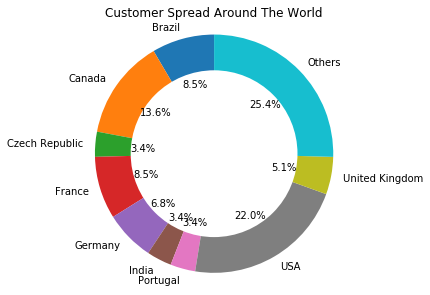

In [20]:
#Reference: https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
import matplotlib.pyplot as plt
df = pd.read_sql_query("""SELECT country, num_of_customers
                          FROM collated_data""", conn)
# Pie chart
labels = df['country']
sizes = df['num_of_customers']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
ax1.set_title("Customer Spread Around The World")
plt.show()

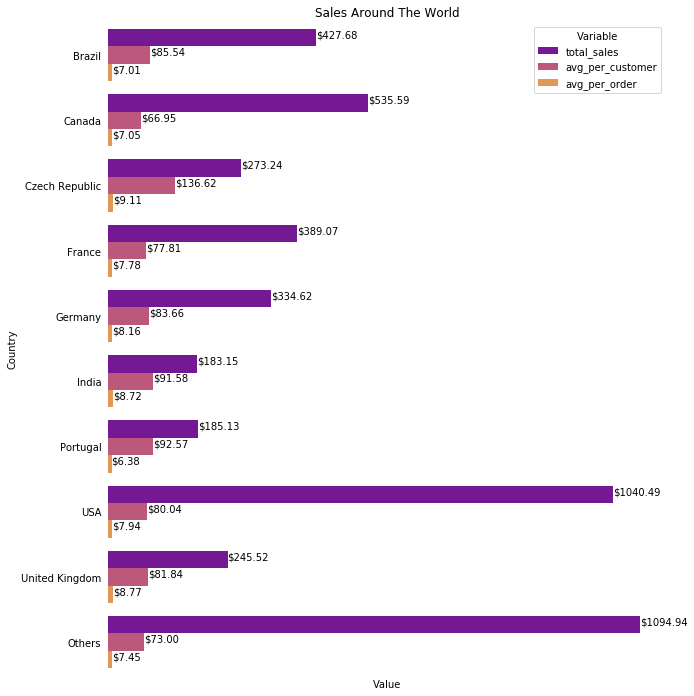

In [21]:
#Reference: https://stackoverflow.com/questions/40877135/plotting-two-columns-of-dataframe-in-seaborn
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_sql_query("""SELECT country, total_sales, avg_per_customer, avg_per_order
                          FROM collated_data""", conn)
melt_df = df.melt(id_vars = 'country').rename(columns=str.title)


# Setting figure size
plt.figure(figsize=(10,12))

# Defining the barplot
ax = sns.barplot(x = 'Value', 
                 y = 'Country',
                 hue = 'Variable',
                 data = melt_df,
                 palette = 'plasma', 
                 orient = 'h')

# Removing spines and setting ticks
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(left = False, bottom = False)
ax.set_xticks([])

#Annotating the bargraph
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,
             "$%1.2f"% rect.get_width())
ax.set_title("Sales Around The World")
plt.show()

**Observations**
- USA and Canada are established markets and a signficant portion of current sales come from these marktets. However the average spent by customers and the average of each invoice in these countries is less in comparison to countries like the Czech Republic whose national purchase average is less than half of these countries.
- The Czech Republic and Portugal have great potential for market expansion. Given that these countries have a different customer base than the US, the customer to spend more is a great sign for expanding in to these markets.
- India shows very promising signs for the Asia region. Despite the poor national sales. The customer spending and average spent per invoice is greater than the current biggest markets. Moreover the customer base is just as much as upcoming markets like the Czech Republic and Portugal. However, India in and of itself is a separate market. Once the customer base has increased in India a separate study would have to be done, as India has a multi-faceted market audience which is extremely sensitive. The parameters used to evaluate other countries cannot be used to evaluate India because of its variable nature.
- The sales in the UK is to say the least, poor. Considering that most of the UK population shares the same language as the US and Canada, the inability to reach the total sales of an upcoming market like the Czech Republic, let alone half the total of Canada's shows that this market need not be looked at further. 

[Index](#Index)

# 7

## Loyalty

**Measuring Customer Loyalty**

Earlier we idenfied a number of countries that have single customers and classified those countries as _Others_. While we could dismiss these countries considering they are not one entity and just a grouping, we would be at a loss. There is no doubt that considering them as a single entity would be incorrect as these are customers spread over various geographical locations.

However, the reason we would be at a loss for not considering them is because these customers are customers. There was something that got them to purchase from Chinook Music. The question is whether it was a one-off purchase of whether they've bought multiple times. If its the former, those sales can be disregarded. However, if its the latter...then there is something more!

Lets analyze by identifying the average number of sales by a customer in each country. The analysis will include countries that have one customer.

This analysis will be done by looking at the total number of invoices of each customer of each country. The next step would be to sum the number of invoices of all customers of a specific country and divide the same by the number of customers in that country.

In [22]:
%%sql
--DROP VIEW customer_loyalty

 * sqlite:///chinook.db
0 rows affected.


[]

In [23]:
%%sql
CREATE VIEW customer_loyalty AS
WITH
--#Identify the number of invoices against each customer
num_of_invoice_per_customer AS
                              (
                               SELECT cus.country, cus.customer_id, COUNT(invoice_id) AS num_of_purchases
                               FROM customer cus
                               INNER JOIN invoice inv ON  cus.customer_id = inv.customer_id
                               GROUP BY cus.country, cus.customer_id
                              ),
--#Identify the average number of times the same customer did another sale
avg_return_customers_per_country AS
                                   (
                                    SELECT country, COUNT(DISTINCT customer_id) AS num_of_customers, 
                                           ROUND(CAST(SUM(num_inv_per_cus.num_of_purchases)AS FLOAT)/COUNT(customer_id),2) AS avg_repeat_purchase
                                    FROM num_of_invoice_per_customer num_inv_per_cus
                                    GROUP BY country
                                   )
SELECT *
FROM avg_return_customers_per_country;

 * sqlite:///chinook.db
(sqlite3.OperationalError) table customer_loyalty already exists
[SQL: CREATE VIEW customer_loyalty AS
WITH
num_of_invoice_per_customer AS
                              (
                               SELECT cus.country, cus.customer_id, COUNT(invoice_id) AS num_of_purchases
                               FROM customer cus
                               INNER JOIN invoice inv ON  cus.customer_id = inv.customer_id
                               GROUP BY cus.country, cus.customer_id
                              ),
avg_return_customers_per_country AS
                                   (
                                    SELECT country, COUNT(DISTINCT customer_id) AS num_of_customers, 
                                           ROUND(CAST(SUM(num_inv_per_cus.num_of_purchases)AS FLOAT)/COUNT(customer_id),2) AS avg_repeat_purchase
                                    FROM num_of_invoice_per_customer num_inv_per_cus
                                    GROUP BY count

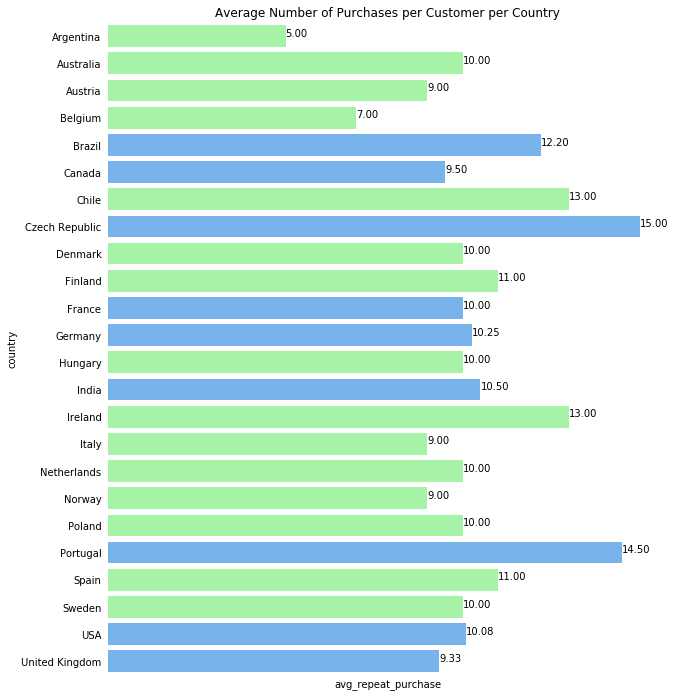

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_sql_query("""SELECT *
                          FROM customer_loyalty""", conn)

# Setting figure size
plt.figure(figsize=(10,12))

#Define color in the barplot
bar_color = ['#66b3ff' if (x > 1) else '#99ff99' for x in df['num_of_customers'].values ]

# Defining the barplot
ax = sns.barplot(x = 'avg_repeat_purchase', 
                 y = 'country',
                 data = df,
                 palette = bar_color,  
                 orient = 'h')

# Removing spines and setting ticks
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(left = False, bottom = False)
ax.set_xticks([])

#Annotating the bargraph
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,
             "%1.2f"% rect.get_width())
ax.set_title("Average Number of Purchases per Customer per Country")
plt.show()

**Observations**
- The barplot highlights countries with one customer in green.
- Customers in the above mentioned countries are repeat customer.They are loyal and interested in purchasing without any incentives.
- In countries like Chile and Ireland, the number of times purchased by their respective single customers is greater than the national average of many countries that have two or more customers.
- These customer could help in market if the organisation considers sign-up or loyalty programs. e.g For every new subscription, the customer could get a free album. Its success depends on how keen the customer would be to take up the offer.
- More details collected from them through surveys could reveal what has kept them coming back to Chinook Music.

[Index](#Index)

# 8

## Singles or Albums

**Analyzing user preference over single tracks vs. complete albums**

As mentioned earlier, the sales model of Chinook Music requires users to buy tracks. The user could buy tracks of the entire album or multiple albums or alternatively buy multiple tracks from multiple albums.

Given current customer trends, most people prefer to listen to  single tracks from various artists as opposed to an album from one artist. [Read more](https://www.forbes.com/sites/bobbyowsinski/2018/03/10/album-dead/?sh=42e54ad69864) 

In order to be sure that this is the customer trend in Chinnok Music deeper analysis is required.

The analysis for this will be carried out by going through every invoice and validating whether all the tracks in the invoice are the same as all the tracks in a set of albums.

The albums to be compared are selected by selecting all the albums associated to the tracks in the invoice. Unless every track in an album exists in the invoice, the invoice would not be considered as an album purchase.

In [39]:
%%sql

WITH 
albumornot AS(
    SELECT inv.invoice_id, --#For each invoice_id
       CASE
        WHEN(
             (--#Identify all tracks in the invoice
              SELECT inv_lin.track_id
              FROM invoice_line inv_lin
              WHERE inv_lin.invoice_id = inv.invoice_id
                 
              EXCEPT
              
              --#Identify all tracks in specific albums   
              SELECT track_id
              FROM track
              WHERE album_id IN (--#Identify albums based on specific tracks
                                 SELECT tra.album_id
                                 FROM track tra
                                 INNER JOIN invoice_line inv_lin2 ON inv_lin2.track_id = tra.track_id
                                 WHERE tra.track_id IN (--#Identify the specific tracks by comparing it 
                                                        --#against the invoice being currently checked
                                                         SELECT il.track_id
                                                         FROM invoice_line il
                                                         WHERE il.invoice_id = inv.invoice_id
                                                        )
                                 )
            )IS NULL
            
        AND           
--# Repeat the same steps above in the reverse order            
            (
             SELECT track_id
             FROM track
             WHERE album_id IN (
                               SELECT tra.album_id
                               FROM track tra
                               INNER JOIN invoice_line inv_lin2 ON inv_lin2.track_id = tra.track_id
                               WHERE tra.track_id IN (
                                                      SELECT il.track_id
                                                      FROM invoice_line il 
                                                      WHERE il.invoice_id = inv.invoice_id
                                                      )
                               )

             EXCEPT

             SELECT inv_lin.track_id
             FROM invoice_line inv_lin
             WHERE inv_lin.invoice_id = inv.invoice_id
            ) IS NULL
        )
        THEN 'yes'
        ELSE 'no'
    END AS album_yes_or_no, 
        (
         SELECT COUNT(*) 
         FROM invoice_line
         WHERE invoice_id = inv.invoice_id
        ) AS num_tracks
FROM invoice inv
ORDER BY inv.invoice_id
)

SELECT album_yes_or_no,
       COUNT(*) AS num_of_invoices, 
       ROUND(COUNT(*) * 100/(
                             SELECT CAST(COUNT(*) AS FLOAT)
                             FROM albumornot
                             ),2) AS percentage_of_invoices
FROM albumornot
GROUP BY album_yes_or_no

 * sqlite:///chinook.db
Done.


album_yes_or_no,num_of_invoices,percentage_of_invoices
no,500,81.43
yes,114,18.57


As seen above, the trend does exist. However, it must be noted that nealry one-fifth of the total sales is accounted for by sales in albums alone. This reveals that album purchases have not died out. Chinook Music could try and carry out surveys to find out why some customers still prefer albums over single tracks.

[Index](#Index)

# 9

## And the award for the most popular artist....

**Identifying the artist whose songs are in most playlists**

Playlists are a mix of user preferred song lists created by customers, that can be uploaded to Chinook. Since the playlist is a preferred collection of songs, it can reveal which artist is most preferred among most customers. 

This could help to monetize customer preference by having more songs of the identified artist on the Chinook library.

In [26]:
%%sql
WITH
--#Get the playlist, track and album identifiers together
artist_list AS(
               SELECT pla_tra.playlist_id, tra.track_id, alb.artist_id
               FROM track tra
               INNER JOIN playlist_track pla_tra ON pla_tra.track_id = tra.track_id
               INNER JOIN album alb ON alb.album_id = tra.album_id
              ),
--#Group the above result by playlist and artist and also include the 
--#number of tracks related to the artist
playlist_artist AS(
                   SELECT al.playlist_id, al.artist_id, count(al.artist_id) AS tot_count
                   FROM artist_list al
                   GROUP BY al.playlist_id, al.artist_id
                  ),
--#From the above result select the artist with the most counts against each playlist and list
--#the same in descending order to get the artist with the most counts
max_artist AS(
              SELECT playlist_id, artist_id, MAX(tot_count) AS artist_max
              FROM playlist_artist
              GROUP BY playlist_id
              ORDER BY artist_max DESC
              LIMIT 1
             )
SELECT name
FROM artist AS most_popular_artist
WHERE artist_id = (SELECT artist_id
                  FROM max_artist)

 * sqlite:///chinook.db
Done.


name
Iron Maiden


[Index](#Index)

# 10

## Purchased vs. Unpurchased tracks

**Identifying the number of unpurchased tracks**

While many tracks may have won over customer preference, there may be many others that may have never seen a purchase invoice. 

We need to identify the number of tracks that have never been purchased.

In [27]:
%%sql
WITH 
#--Identify the unpurchased tracks
unpurchased_tracks AS(
                      SELECT DISTINCT track_id
                      FROM track
                      EXCEPT
                      SELECT DISTINCT track_id
                      FROM invoice_line
                     )
SELECT (
        SELECT COUNT(DISTINCT track_id)
        FROM invoice_line
       ) AS num_of_purchased_tracks, --#Count the purchased tracks
       COUNT(*) AS num_of_unpurchased_tracks, --#Count the unpurchased tracks
       (
        SELECT COUNT(DISTINCT track_id) --#Count the total number of tracks
        FROM track
       ) AS total_num_of_tracks
FROM unpurchased_tracks

 * sqlite:///chinook.db
Done.


num_of_purchased_tracks,num_of_unpurchased_tracks,total_num_of_tracks
1806,1697,3503


Slightly less than half the number of tracks in the inventory have never been purchased. It would be interesting to see which genre has the most number of unpurchased tracks.

In [28]:
%%sql
WITH
--#Identify unpurchased tracks
unpurchased_tracks AS(
                      SELECT DISTINCT track_id
                      FROM track
                      EXCEPT
                      SELECT DISTINCT track_id
                      FROM invoice_line
                     ),
--#Identify Genre of unpurchased tracks
unpurchased_tracks_info AS(
                           SELECT track_id, genre_id
                           FROM track
                           WHERE track_id IN (
                                              SELECT *
                                              FROM unpurchased_tracks
                                             )
                          )
--#Identify the percentage of tracks by Genre that is unpurchased
SELECT gen.name AS genre_name, 
       ROUND(CAST(COUNT(unp_tra_inf.track_id) AS FLOAT) * 100 /
                                          (
                                           SELECT COUNT(*)
                                           FROM unpurchased_tracks
                                          )
                                    ,2) AS percentage_of_unpurchased_genres
FROM unpurchased_tracks_info unp_tra_inf
INNER JOIN genre gen ON gen.genre_id = unp_tra_inf.genre_id
GROUP BY genre_name
ORDER BY percentage_of_unpurchased_genres DESC

 * sqlite:///chinook.db
Done.


genre_name,percentage_of_unpurchased_genres
Latin,27.11
Rock,22.51
Alternative & Punk,9.19
Metal,8.01
TV Shows,5.36
Jazz,4.07
Drama,3.71
Classical,3.42
Soundtrack,2.24
Reggae,2.12


Almost 50% of the unpurchased tracks seem to be from the Latin and Rock genres. These genres seem to be in a league of their own when it comes to unpurchased tracks.

More surveys need to be conducted to better understand customer preferences and keep stock of music based on current trends. Given that nearly half the inventory remains unpurchased, there is something amiss in Chinook Music's understanding of current trends.

[Index](#Index)

# 11

## Have you got what they love?

**Analysing whether the inventory is a reflection of customer preference**

There are many tracks in the Chinook Music system. However, a number of these tracks have never been sold. This raises the question, do the tracks in the inventory reflect sales popularity?

It can be assumed that sales popularity is driven by what customers prefer. If the inventory has tracks that customers prefer that drives sales.

To put it another way, is the customer's preference reflected in the inventory? The question cannot be answered by looking at the tracks themselves. The DB does not contain such details as the pitch or tone of the music it contains. With that kind of information we could have said that tracks with specific tones and pitch are being sold and all we needed to verify was whether tracks with similar charachteristics were being held in the inventory.

What we do have is genre of each track. Using the same logic we could check whether the most popular genres that are sold are being stocked.

We can safely assume that if a genre is preferred by most customers, all tracks associated to the genre would have been sold. If not even a single track associated to a genre has ever been sold, we could also assume that customers do no prefer that genre. 

One could argue that the reason a customer may have never bought a track from a genre from which a track has never been sold is because the customer was unaware  of it. But that would mean the sales team is not doing a good job promoting the tracks in Chinook. This, as we saw earlier, is highly unlikely as the sales team have been maintaining good performance.

With these assumptions and information we could first take a look at the most popular genres in most invoices and verify whether the same is reflected in the most common genre among the tracks in the inventory.

This analysis can begin by identifying which 10 genres are represented by the tracks in the inventory.

In [31]:
%%sql
SELECT gen.name AS genre, 
       ROUND(CAST(COUNT(tra.track_id) AS FLOAT) * 100 /
                                          (
                                           SELECT COUNT(*)
                                           FROM track
                                          )
                                    ,2) AS inventory_share_of_tracks_by_genre
FROM track tra
INNER JOIN genre gen ON gen.genre_id = tra.genre_id
GROUP BY tra.genre_id
ORDER BY share_of_tracks_by_genre DESC
LIMIT 10

 * sqlite:///chinook.db
Done.


genre,share_of_tracks_by_genre
Rock,37.03
Latin,16.53
Metal,10.68
Alternative & Punk,9.48
Jazz,3.71
TV Shows,2.65
Blues,2.31
Classical,2.11
Drama,1.83
R&B/Soul,1.74


Lets compare the above finding against the top 10 genres that are represented most in the invoices.

In [32]:
%%sql
SELECT gen.name AS genre_tracks, ROUND(CAST(COUNT(inv_lin.track_id) AS FLOAT) * 100 /
                                          (
                                           SELECT COUNT(*)
                                           FROM invoice_line
                                          )
                                    ,2) AS invoice_share_of_tracks_by_genre
FROM invoice_line inv_lin
INNER JOIN track tra ON tra.track_id = inv_lin.track_id
INNER JOIN genre gen ON gen.genre_id = tra.genre_id
GROUP BY gen.name
ORDER BY share_of_tracks_by_genre DESC
LIMIT 10

 * sqlite:///chinook.db
Done.


genre_tracks,share_of_tracks_by_genre
Rock,55.39
Metal,13.01
Alternative & Punk,10.34
Latin,3.51
R&B/Soul,3.34
Blues,2.61
Jazz,2.54
Alternative,2.46
Easy Listening,1.56
Pop,1.32


A more detailed analysis can be made if we tabulate the results.

In [50]:
%%sql
DROP VIEW inventory_vs_invoice

 * sqlite:///chinook.db
Done.


[]

In [52]:
%%sql
CREATE VIEW inventory_vs_invoice AS
WITH
--#Identify the share of each genre in the inventory
genre_share_in_tracks AS
                        (SELECT gen.name AS genre_tracks, 
                                ROUND(CAST(COUNT(tra.track_id) AS FLOAT) * 100 /
                                                                  (
                                                                   SELECT COUNT(*)
                                                                   FROM track
                                                                  )
                                                            ,2) AS share_of_tracks_by_genre,
                                COUNT(tra.track_id) AS total_tracks_by_genre
                        FROM track tra
                        INNER JOIN genre gen ON gen.genre_id = tra.genre_id
                        GROUP BY tra.genre_id),
--#Identify the share of each genre in the invoice lines based on tracks purchased    
genre_share_in_invoice_line AS
                              (SELECT gen.name AS genre_invoice_line, 
                                      ROUND(CAST(COUNT(inv_lin.track_id) AS FLOAT) * 100 /
                                                                          (
                                                                           SELECT COUNT(*)
                                                                           FROM invoice_line
                                                                          )
                                                                    ,2) AS share_of_tracks_by_genre,
                                      COUNT(DISTINCT inv_lin.track_id) AS total_sold_by_genre
                              FROM invoice_line inv_lin
                              INNER JOIN track tra ON tra.track_id = inv_lin.track_id
                              INNER JOIN genre gen ON gen.genre_id = tra.genre_id
                              GROUP BY genre_invoice_line)
SELECT sha_in_tra.genre_tracks AS genre, 
       sha_in_tra.share_of_tracks_by_genre AS 'share_by_genre_in_inventory',
        --#Calculates number of tracks in each genre
       sha_in_tra.total_tracks_by_genre AS 'total_in_inventory', 
       sha_in_inv.share_of_tracks_by_genre AS 'share_by_genre_in_tracks_sold',
        --#Calculates number of tracks sold in each genre
       sha_in_inv.total_sold_by_genre AS 'total_sold',
        --#Calculates percentage of tracks sold based on what is in the inventory
       ROUND(CAST(sha_in_inv.total_sold_by_genre AS FLOAT) * 100 / sha_in_tra.total_tracks_by_genre,2) AS 'percentage_sold'
FROM genre_share_in_tracks AS sha_in_tra
LEFT JOIN genre_share_in_invoice_line sha_in_inv ON sha_in_tra.genre_tracks = sha_in_inv.genre_invoice_line
ORDER BY sha_in_inv.share_of_tracks_by_genre DESC;

 * sqlite:///chinook.db
Done.


[]

In [53]:
%%sql
SELECT *
FROM inventory_vs_invoice
ORDER BY percentage_sold DESC

 * sqlite:///chinook.db
Done.


genre,share_by_genre_in_inventory,total_in_inventory,share_by_genre_in_tracks_sold,total_sold,percentage_sold
Easy Listening,0.69,24,1.56,24,100.0
Electronica/Dance,0.86,30,1.16,29,96.67
R&B/Soul,1.74,61,3.34,55,90.16
Alternative,1.14,40,2.46,34,85.0
Rock,37.03,1297,55.39,915,70.55
Blues,2.31,81,2.61,56,69.14
Metal,10.68,374,13.01,238,63.64
Hip Hop/Rap,1.0,35,0.69,21,60.0
Alternative & Punk,9.48,332,10.34,176,53.01
Pop,1.37,48,1.32,25,52.08


**Observations**:
- Easy Listening genre is the best performer with regards to customer preference being reflected in the inventory. All tracks in this genre have been purchased by customers. 
- The worst perfomer seems to be tracks in the World genre. This is considering that it has 28 tracks and not one has been sold.
- There are multiple genres which have never seen a single sale.
- Among the poor performing genres that have seen a sale, the worst rate of sales is exhibited by the Drama genre with just 1.56% of its tracks ever seeing a sale.
- While the Drama genre has had poor sales, its representation in the inventory is only 1.83%
- The Latin genre has nearly 17% representation in the inventory but its stake in the percentage of tracks sold is only 3.5%.
- The Rock genre holds more than 50% of the total sales however it forms only 37% percent of the total inventory.
- While tracks in the Easy Listening genre have completely sold out, these tracks only form 0.69% of the total inventory. 

What is clear from the observations above is that sales popularity is not reflected in the range of tracks. While genres like Easy listening are quiet popular, they have minimal range in the online store. 

On the other hand Latin tracks which are the second most represented tracks in the Chinook inventory  make up only 3.51% of the total tracks sold.

Slightly more than 3% of the total inventory has never seen the light of sales.

One could assign a score to the inventory based on the sales of the tracks in it by taking the ratio of the tracks sold to the number of tracks in the inventory.

In [48]:
%%sql
SELECT ROUND(CAST(SUM(total_sold) AS FLOAT) * 100 / SUM(total_in_inventory),2) AS 'inventory_vs_sales_score'
FROM inventory_vs_invoice

 * sqlite:///chinook.db
Done.


inventory_vs_sales_score
51.56


**Suggestions**:
- Chinook Music needs to take a closer look at inventory.
- Considering that nearly 50% of tracks are unsold more work needs to be done on what kinds of music must be considered in its inventory.
- More tracks associated to genres like Easy Listening, Electronica/Dance, R&B/Soul	and Alternative must be considered.
- For genres that have never seen a sale, Chinook Music must do more research to find target audiences to help generate sales.

[Index](#Index)

# 12

## Protected vs. UnProtected....media!

**Analysis of the protected status of a media affects track sales**

Every track in the Chinook Music database is associated to a media format. Of the five media formats only two have been identified as protected in their name.

If a media file is protected, it contains data, not only about the music but also about the customer that purchased the track. This prevents the media file from ever being shared (sharing music is illegal.. if you didn't know). [Read more](https://www.lifewire.com/why-are-itunes-files-purchased-protected-2000439)

We need to identify how sales are affected based on the protected status of a track. The media table does not clearly specify this status. An extra column will be used as an indicator for the same.

In [34]:
%%sql
DROP VIEW protected_status

 * sqlite:///chinook.db
Done.


[]

In [35]:
%%sql
CREATE VIEW protected_status AS
SELECT *
FROM (SELECT *, 
             CASE
                 WHEN media_type_id IN (1, 4, 5) THEN 'unprotected'
                 ELSE 'protected'
             END AS status
     FROM media_type);
SELECT *
FROM protected_status

 * sqlite:///chinook.db
Done.
Done.


media_type_id,name,status
1,MPEG audio file,unprotected
2,Protected AAC audio file,protected
3,Protected MPEG-4 video file,protected
4,Purchased AAC audio file,unprotected
5,AAC audio file,unprotected


Since we can now identify the protected status of each track sold, we can summarize the percentage of protected and unprotected tracks that were sold.

In [36]:
%%sql
WITH protected_status_applied AS
                                (SELECT inv_lin.track_id, pro_sta.status
                                 FROM invoice_line inv_lin
                                 INNER JOIN track tra ON inv_lin.track_id = tra.track_id
                                 INNER JOIN protected_status pro_sta ON tra.media_type_id = pro_sta.media_type_id
                                 )
SELECT status, ROUND(CAST(COUNT(*) AS FLOAT) * 100 / 
             (SELECT COUNT(*)
             FROM protected_status_applied),2) AS 'percentage_sold_based_on_media_status'
FROM protected_status_applied
GROUP BY status

 * sqlite:///chinook.db
Done.


status,Percentage Sold
protected,9.29
unprotected,90.71


Clearly most customers prefer unprotected tracks. Beside the fact that they cannot be tracked, the tracks can be used between multiple devices as opposed to being played in a single device.

[Index](#Index)

# 13

## Conclusion

Chinook Music is an online music store with a presence in multiple countries across the world. After having analysed their existing data, ABC Music Consultants have made many findings which have been detailed above.

While their customer spread in different countries around the world can be slightly misleading, their customer loyalty is undeniable. This loyalty is a reflection of the performance of their sales staff in ensuring that every one of their customers are managed individually. Chinook Music does have some work on its current inventory. But given their loyal customer base and some research they should be able to drive more and better sales.

Rest assured, Chinook Music can hold their own when it comes to music sales.

[Index](#Index)

# 14

## Acknowledgement

- This is a guided project by Dataquest to gain a more concrete understanding on the concepts of SQL
- The project was done in SQLite
- For details on generating plots from SQL queries refer [Dataquest](https://www.dataquest.io/blog/python-pandas-databases/)
- ABC Music Consultants and Chinook Music are fictional entities. The image attached to the beginning of this report was taken from [here](https://www.abcmusic.co/)

# 15

## Learnings

- A CREATE VIEW statement cannot come after a WITH statement. The WITH statement must be within the 
CREATE view statement
e.g. CREATE VIEW <view name> AS
        WITH
        SUbquery1, 
        Subquery 2
        SELECT * FROM (above queries
     SELECT  FROM viewname This is correct

    WITH
        SUbquery1, 
        Subquery 2
    CREATE VIEW <view_name> AS ---- This is incorrect and comes up with the error (sqlite3.OperationalError) near "CREATE": syntax error

[Index](#Index)